# Implementing Discrete Cosine Transform (DCT) Using Python

## Table of Contents
* [Introduction](#Introduction)
* [Python Implementation](#Implementation)
* [Testing the Code](#Testing)

<a name="Introduction"></a>

## Introduction

Discrete Cosine Transform (DCT) is one of the methods that transform an image in **space-domain** to its corresponding **frequency-domain**. The transformed image can also be returned back to its original format by using the inverse DCT. Discrete Fourier Transform (DFT) is a complex type of transform. That is, the output of DFT is a matrix of complex numbers having both the real and imaginary parts (cosine and sine). However, we may need to change the image only to its corresponding real-number transformation. So, DCT is the one that computes only the real (cosine) part of the transformation while keeping the similar format as the DFT.

Let the size of an input image be NxN.

The general formula for ***Forward DCT*** is:

$$
\begin{align}
C(u,v) = \tau(u,v)\sum_{x=0}^{N-1}\sum_{y=0}^{N-1}f(x,y) cos(\frac{(2x+1)}{2N}u\pi)cos(\frac{(2y+1)}{2N}v\pi) \; where \; u,v=0,1,2,...N-1
\end{align}
$$

$\hspace{7cm} \tau(u, v) = \frac{1}{N}$ for u=0, v=0

$\hspace{8.25cm}=\frac{2}{N}$ for otherwise

The ***forward DCT kernel*** is:
$$
\begin{align}
g(x,y,u,v) = \tau(u,v)\sum_{x=0}^{N-1}\sum_{y=0}^{N-1} cos(\frac{(2x+1)}{2N}u\pi)cos(\frac{(2y+1)}{2N}v\pi)
\end{align}
$$

Similarly, the ***Inverse DCT*** is:
$$
\begin{align}
f(x,y) = \sum_{u=0}^{N-1}\sum_{v=0}^{N-1}\tau(u,v)C(u,v) cos(\frac{(2x+1)}{2N}u\pi)cos(\frac{(2y+1)}{2N}v\pi) \; where \; x,y=0,1,2,...N-1
\end{align}
$$

In the next section, the forward DCT will be implemented in python. It will be tested with real images. Finally, its running time will be computed and visualized by using multiple images having different images.

<a name="Implementation"></a>
## Python Implementation

First of all, let's import the necessary python libraries

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

#import matplotlib.image as img
import PIL.Image as Image 

import math
import cmath

import time

import csv

from numpy import binary_repr


The functions below implement the common image handling

In [2]:
def generateBlackAndWhiteSquareImage(imgSize):
    """
    Generates a square-sized black and white image with a given input size.

    Parameters
    ----------
    imgSize : int
        Input number that stores the dimension of the square image to be generated.

    Returns
    -------
    imge : ndarray
        The generated black and white square image.
    """

    #Creating a matrix with a given size where all the stored values are only zeros (for initialization)
    imge = np.zeros([imgSize, imgSize], dtype=int)

    #Starting and ending indices of the white part of the image.
    ind1 = imgSize/4
    ind2 = ind1 + (imgSize/2)

    #Make a part of the image as white (255)
    imge[ind1:ind2, ind1:ind2] = np.ones([imgSize/2, imgSize/2], dtype=int)*255

    #return the resulting image
    return imge
    
def generateImagesWithResizedWhite(imge):
    """
    Generates images with the same size as the original but with a resized white part of them.
    """

    N = imge.shape[0]

    imges = []
    i = N/2
    while i >= 4:
        j = (N - i)/2

        #Starting and ending indices for the white part.
        indx1 = j
        indx2 = j+i

        #Draw the image.
        imgeNew = np.zeros([N, N],dtype=int)
        imgeNew[indx1:indx2, indx1:indx2] = np.ones([i, i], dtype=int)*255

        #Add the image to the list.
        imges.append(imgeNew)

        i = i/2

    return imges

def resizeImage(imge, newSize):        
    """
    Reduces the size of the given image.

    Parameters
    ----------
    imge : ndarray
        Input array that stores the image to be resized.

    Returns
    -------
    newSize : int
        The size of the newly generated image.
    """

    #Compute the size of the original image (in this case, only # of rows as it is square)
    N = imge.shape[0]

    #The ratio of the original image as compared to the new one.
    stepSize = N/newSize

    #Creating a new matrix (image) with a black color (values of zero)
    newImge = np.zeros([N/stepSize, N/stepSize])

    #Average the adjacent four pixel values to compute the new intensity value for the new image.
    for i in xrange(0, N, stepSize):
        for j in xrange(0, N, stepSize):
            newImge[i/stepSize, j/stepSize] = np.mean(imge[i:i+stepSize, j:j+stepSize])

    #Return the new image
    return newImge

def generateImages(imgSizes=[128, 64, 32, 16, 8]): 
    """
    Generates images with different sizes
    """
    #Create an empty list of images to save the generated images with different sizes.
    images = []

    #Generate the first and biggest image
    imge = generateBlackAndWhiteSquareImage(imgSizes[0])

    #Add to the images list
    images.append(imge)

    #Generate the resized and smaller images with different sizes.
    for i in range(1, len(imgSizes)):
        size = imgSizes[i]
        images.append(resizeImage(imge, size))
        
    return images

The python class below implements the DCT transformation algorithm.

In [3]:
class DCT(object):
    """
    This class DCT implements all the procedures for transforming a given 2D digital image
    into its corresponding frequency-domain image (Forward DCT Transform)
    """
    
    @classmethod
    def __computeSinglePoint2DCT(self, imge, u, v, N):
        """
        A private method that computes a single value of the 2D-DCT from a given image.

        Parameters
        ----------
        imge : ndarray
            The input image.
        
        u : ndarray
            The index in x-dimension.
            
        v : ndarray
            The index in y-dimension.

        N : int
            Size of the image.
            
        Returns
        -------
        result : float
            The computed single value of the DCT.
        """
        result = 0

        for x in xrange(N):
            for y in xrange(N):
                result += imge[x, y] * math.cos(((2*x + 1)*u*math.pi)/(2*N)) * math.cos(((2*y + 1)*v*math.pi)/(2*N))

        #Add the tau value to the result
        if (u==0) and (v==0):
            result = result/N
        elif (u==0) or (v==0):
            result = (math.sqrt(2.0)*result)/N
        else:
            result = (2.0*result)/N

        return result
    
    @classmethod
    def __computeSinglePointInverse2DCT(self, imge, x, y, N):
        """
        A private method that computes a single value of the 2D-DCT from a given image.

        Parameters
        ----------
        imge : ndarray
            The input image.
        
        u : ndarray
            The index in x-dimension.
            
        v : ndarray
            The index in y-dimension.

        N : int
            Size of the image.
            
        Returns
        -------
        result : float
            The computed single value of the DCT.
        """
        result = 0

        for u in xrange(N):
            for v in xrange(N):
                if (u==0) and (v==0):
                    tau = 1.0/N
                elif (u==0) or (v==0):
                    tau = math.sqrt(2.0)/N
                else:
                    tau = 2.0/N            
                result += tau * dctImge[u, v] * math.cos(((2*x + 1)*u*math.pi)/(2*N)) * math.cos(((2*y + 1)*v*math.pi)/(2*N))

        return result
    
    @classmethod
    def computeForward2DDCT(self, imge):
        """
        Computes/generates the 2D DCT of an input image in spatial domain.

        Parameters
        ----------
        imge : ndarray
            The input image to be transformed.

        Returns
        -------
        final2DDFT : ndarray
            The transformed image.
        """
 
        # Assuming a square image
        N = imge.shape[0]
        final2DDCT = np.zeros([N, N], dtype=float)
        for u in xrange(N):
            for v in xrange(N):
                #Compute the DCT value for each cells/points in the resulting transformed image.
                final2DDCT[u, v] = DCT.__computeSinglePoint2DCT(imge, u, v, N)
        return final2DDCT
    
    @classmethod
    def computeInverse2DDCT(self, imge):
        """
        Computes/generates the 2D DCT of an input image in spatial domain.

        Parameters
        ----------
        imge : ndarray
            The input image to be transformed.

        Returns
        -------
        final2DDFT : ndarray
            The transformed image.
        """
 
        # Assuming a square image
        N = imge.shape[0]
        finalInverse2DDCT = np.zeros([N, N], dtype=float)
        for x in xrange(N):
            for y in xrange(N):
                #Compute the DCT value for each cells/points in the resulting transformed image.
                finalInverse2DDCT[x, y] = DCT.__computeSinglePointInverse2DCT(imge, x, y, N)
        return finalInverse2DDCT
    
    @classmethod
    def normalize2DDCTByLog(self, dctImge):
        """
        Computes the log transformation of the transformed DCT image to make the range
        of the DCT values b/n 0 to 255
        
        Parameters
        ----------
        dctImge : ndarray
            The input DCT transformed image.

        Returns
        -------
        dctNormImge : ndarray
            The normalized version of the transformed image.
        """
        
        #Normalize the DCT values of a transformed image:
        dctImge = np.absolute(dctImge)
        dctNormImge = (255/ math.log10(255)) * np.log10(1 + (255/(np.max(dctImge))*dctImge))
        
        return dctNormImge
        

<a name="Testing"></a>
## Testing the Code

### Testing the DCT Algorithm

First, we generate an 8-bit gray scale image as a 64x64 matrix and display it.

Image Size: (64, 64)


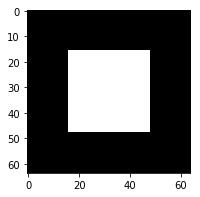

In [4]:
imge = generateBlackAndWhiteSquareImage(64)
print "Image Size:", imge.shape
plt.figure(figsize=(3,3))
plt.imshow(imge, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
plt.show()

And we will also load another image from file:

Image Size: (256, 256)


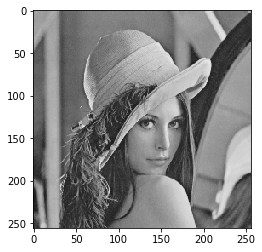

In [5]:
#Read an image file
imgeLena = Image.open("Images/lena_gray_256.tif") # open an image

#Convert the image file to a matrix
imgeLena = np.array(imgeLena)

#Convert the uint datatype of the matrix values into 'int' for using the negative values
imge = imge.astype('int')

#Display the image:
print "Image Size:", imgeLena.shape
plt.imshow(imgeLena, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
plt.show()

The image is then resized to 64x64 for making the DCT algorithm faster:

Image Size: (64, 64)


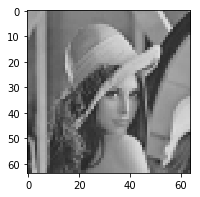

In [6]:
imgeLena = resizeImage(imgeLena, 64)

print "Image Size:", imgeLena.shape

plt.figure(figsize=(3,3))
plt.imshow(imgeLena, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
plt.show()

Now, the DCT is computed for both the images as follows:

In [7]:
#1. For image 1:
dctImge = DCT.computeForward2DDCT(imge)

#2. For image 2:
dctImgeLena = DCT.computeForward2DDCT(imgeLena)


Normalize the computed DCT results:

In [8]:
#1. For image 1:
dctNormImge = DCT.normalize2DDCTByLog(dctImge)

#1. For image 2:
dctNormImgeLena = DCT.normalize2DDCTByLog(dctImgeLena)

Now, all the results are displayed for both the input images:

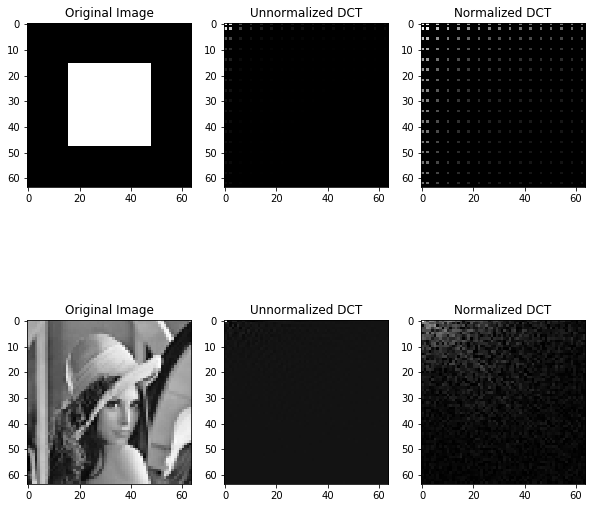

In [9]:
fig, axarr = plt.subplots(2, 3, figsize=(10, 10))

#For image 1
axarr[0][0].imshow(imge, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
axarr[0][0].set_title('Original Image')

axarr[0][1].imshow(np.absolute(dctImge), cmap=plt.get_cmap('gray'))
axarr[0][1].set_title('Unnormalized DCT')

axarr[0][2].imshow(dctNormImge, cmap=plt.get_cmap('gray'))
axarr[0][2].set_title('Normalized DCT')

#For image 2
axarr[1][0].imshow(np.absolute(imgeLena), cmap=plt.get_cmap('gray'))
axarr[1][0].set_title('Original Image')

axarr[1][1].imshow(dctImgeLena, cmap=plt.get_cmap('gray'))
axarr[1][1].set_title('Unnormalized DCT')
axarr[1][2].imshow(dctNormImgeLena, cmap=plt.get_cmap('gray'))
axarr[1][2].set_title('Normalized DCT')
#fig.set_figwidth(15)

plt.show()

Now, the DCT results can be return back to their original form by using inverse DCT. (Only for the first image done).

Note: the result is rounded to the nearest integer to eliminate the very small decimall points which have come due to floating point precision.

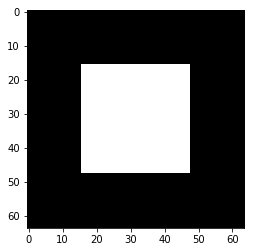

In [10]:
inverseImge = np.round(DCT.computeInverse2DDCT(dctImge))
plt.imshow(inverseImge, cmap=plt.get_cmap('gray'))
plt.show()

### Computing and Visualizing the DCT Running Time

After the implementation of the DCT algorithm is fully tested, its running time is computed for different image sizes.

First the images with different sizes are generated:

In [11]:
#Generate images
imgSizes = [128, 64, 32, 16, 8]
images = generateImages(imgSizes)

After the images are generated, the DCT running time is analyzed as follows: 

In [12]:
# A list that stores the running time of the DCT algorithm for images with different size.
runningTimeDCT = []

#For each image...
for i, imge in enumerate(images):
    
    #Compute the image size
    N = imge.shape[0]
    
    print "Computing for ", N, "x", N, "image..."
    
    #Save the starting time.
    startTime = time.time()

    #Compute the DCT of the image.
    dctImge = DCT.computeForward2DDCT(imge)
    
    #Save the running time
    runningTimeDCT.append((time.time() - startTime)/60.0)

Computing for  128 x 128 image...
Computing for  64 x 64 image...
Computing for  32 x 32 image...
Computing for  16 x 16 image...
Computing for  8 x 8 image...


In [13]:
result = zip(imgSizes, runningTimeDCT)
np.savetxt("RunningTimes/runningTimeDCT.csv", np.array(result), delimiter=',')

#Load the running time for DFT from the separate post
runningTimeDFT = np.loadtxt("RunningTimes/runningTimeDFT.csv", delimiter =',')

Finally, the computation times are visualized by using line plot:

['128x128', '64x64', '32x32', '16x16', '8x8']


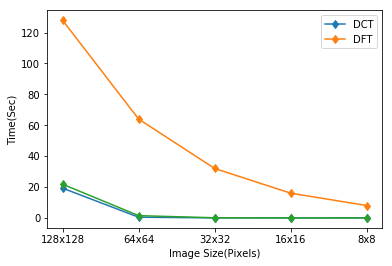

In [14]:
#Plot the running times
plt.plot(xrange(len(runningTimeDCT)), runningTimeDCT, '-d')
plt.hold
plt.plot(xrange(len(runningTimeDFT)), runningTimeDFT, '-d')

xlabels = [str(imge.shape[0]) + 'x' + str(imge.shape[0]) for imge in images]
print xlabels
plt.xticks(xrange(len(runningTimeDCT)), xlabels)
plt.xlabel("Image Size(Pixels)")
plt.ylabel("Time(Sec)")
plt.legend(['DCT', 'DFT'])
plt.show()

From the above results, we can conclude that DCT is faster than DFT as it only calculates the real part.